## Define model

In [1]:
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_compute_dtype=torch.bfloat16,
      bnb_4bit_use_double_quant=True,
      bnb_4bit_quant_type="nf4",
)

/home/niels/python_projects/LLaVA/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
from transformers import LlavaForConditionalGeneration

device_map = {"": torch.cuda.current_device()}

model_id = "llava-hf/llava-1.5-7b-hf"

model = LlavaForConditionalGeneration.from_pretrained(model_id,
                                                      device_map=device_map,
                                                      quantization_config=quantization_config)

config.json: 100%|██████████| 954/954 [00:00<00:00, 5.59MB/s]
model.safetensors.index.json: 100%|██████████| 70.1k/70.1k [00:00<00:00, 108MB/s]
model-00001-of-00003.safetensors: 100%|██████████| 4.99G/4.99G [01:22<00:00, 60.4MB/s]
model-00002-of-00003.safetensors: 100%|██████████| 4.96G/4.96G [01:48<00:00, 45.8MB/s]
model-00003-of-00003.safetensors: 100%|██████████| 4.18G/4.18G [15:15<00:00, 4.56MB/s]
generation_config.json: 100%|██████████| 141/141 [00:00<00:00, 991kB/s]


In [31]:
# from peft import prepare_model_for_kbit_training

# model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

In [32]:
# from peft import LoraConfig, get_peft_model

# def find_all_linear_names(model):
#     cls = torch.nn.Linear
#     lora_module_names = set()

#     # TODO check this
#     multimodal_keywords = ['multimodal_projector', 'vision_tower', 'vision_resampler']
#     for name, module in model.named_modules():
#         if any(mm_keyword in name for mm_keyword in multimodal_keywords):
#             continue
#         if isinstance(module, cls):
#             names = name.split('.')
#             lora_module_names.add(names[0] if len(names) == 1 else names[-1])

#     if 'lm_head' in lora_module_names: # needed for 16-bit
#         lora_module_names.remove('lm_head')
#     return list(lora_module_names)

# lora_config = LoraConfig(
#     r=128,
#     lora_alpha=256,
#     target_modules=find_all_linear_names(model),
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
# )
# model = get_peft_model(model, lora_config)

## Create PyTorch dataset

In [2]:
from typing import Sequence, Dict
from llava.constants import DEFAULT_IMAGE_TOKEN

def preprocess_multimodal(sources: Sequence[str], is_multimodal=True) -> Dict:
    if not is_multimodal:
        return sources

    for source in sources:
        for sentence in source:
            if DEFAULT_IMAGE_TOKEN in sentence['value']:
                sentence['value'] = sentence['value'].replace(DEFAULT_IMAGE_TOKEN, '').strip()
                sentence['value'] = DEFAULT_IMAGE_TOKEN + '\n' + sentence['value']
                sentence['value'] = sentence['value'].strip()
                # if "mmtag" in conversation_lib.default_conversation.version:
                #     sentence['value'] = sentence['value'].replace(DEFAULT_IMAGE_TOKEN, '<Image>' + DEFAULT_IMAGE_TOKEN + '</Image>')
            replace_token = DEFAULT_IMAGE_TOKEN
            sentence["value"] = sentence["value"].replace(DEFAULT_IMAGE_TOKEN, replace_token)

    return sources

In [18]:
from torch.utils.data import Dataset
import json
from PIL import Image
import os
import copy
import torch

from llava.train.train import preprocess


def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


class SFTDataset(Dataset):
    """Dataset for supervised fine-tuning (SFT) of LLaVa."""

    def __init__(self, data_path: str, image_folder, processor):
        super(SFTDataset, self).__init__()
        list_data_dict = json.load(open(data_path, "r"))

        self.list_data_dict = list_data_dict
        self.image_folder = image_folder
        self.processor = processor
        self.is_multimodal = True
        
    def __len__(self):
        return len(self.list_data_dict)

    @property
    def lengths(self):
        length_list = []
        for sample in self.list_data_dict:
            img_tokens = 128 if 'image' in sample else 0
            length_list.append(sum(len(conv['value'].split()) for conv in sample['conversations']) + img_tokens)
        return length_list

    @property
    def modality_lengths(self):
        length_list = []
        for sample in self.list_data_dict:
            cur_len = sum(len(conv['value'].split()) for conv in sample['conversations'])
            cur_len = cur_len if 'image' in sample else -cur_len
            length_list.append(cur_len)
        return length_list

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        sources = self.list_data_dict[i]
        if isinstance(i, int):
            sources = [sources]
        assert len(sources) == 1, "Don't know why it is wrapped to a list"  # FIXME
        
        if 'image' in sources[0]:
            image_file = self.list_data_dict[i]['image']
            image = Image.open(os.path.join(self.image_folder, image_file)).convert('RGB')
            image = expand2square(image, tuple(int(x*255) for x in self.processor.image_processor.image_mean))
            image = self.processor.image_processor(image, return_tensors='pt').pixel_values[0]
            
            sources = preprocess_multimodal(copy.deepcopy([e["conversations"] for e in sources]),
                                            is_multimodal=self.is_multimodal)
        else:
            sources = copy.deepcopy([e["conversations"] for e in sources])
        
        data_dict = preprocess(
            sources,
            self.processor.tokenizer,
            has_image=('image' in self.list_data_dict[i]))
        if isinstance(i, int):
            data_dict = dict(input_ids=data_dict["input_ids"][0],
                             labels=data_dict["labels"][0])

        # image exist in the data
        if 'image' in self.list_data_dict[i]:
            data_dict['image'] = image
        elif self.is_multimodal:
            # image does not exist in the data, but the model is multimodal
            crop_size = self.processor.image_processor.crop_size
            data_dict['image'] = torch.zeros(3, crop_size['height'], crop_size['width'])

        return data_dict

In [19]:
from transformers import AutoProcessor

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

# update model_max_length of tokenizer
processor.tokenizer.model_max_length = 2048

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
from huggingface_hub import hf_hub_download

filepath = hf_hub_download(repo_id="liuhaotian/LLaVA-Instruct-150K", filename="llava_instruct_80k.json", repo_type="dataset")

train_dataset = SFTDataset(data_path=filepath,
                           image_folder="/home/niels/python_projects/LLaVA/train2017",
                           processor=processor)

In [21]:
example = train_dataset[0]
example.keys()

dict_keys(['input_ids', 'labels', 'image'])

In [22]:
processor.decode([i for i in example["input_ids"] if i not in [-100, -200] ])

"<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER:  \nWhat is the man doing in the back of the pickup truck? ASSISTANT: The man is sitting on top of piled objects or belongings loaded into the back of a pickup truck.</s> USER: Is the man holding anything in his hands? ASSISTANT: Yes, the man is holding a beer in his hand while sitting on top of the objects in the back of the pickup truck.</s> USER: What color is the pickup truck? ASSISTANT: The pickup truck is white.</s> USER: Is the man sitting or standing? ASSISTANT: The man is sitting on top of the piled objects in the back of the pickup truck.</s> USER: What could be the possible reasons for the man sitting on top of the possessions in the back of the pickup truck? ASSISTANT: There could be several reasons for the man sitting on top of his possessions in the back of the pickup truck:\n\n1. Moving: The man might be movi

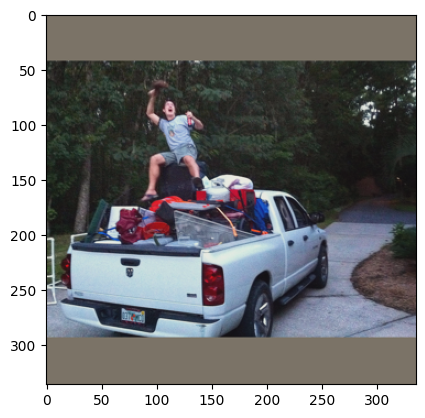

In [24]:
# denormalize the image to see it
import numpy as np
import matplotlib.pyplot as plt

image = example["image"].numpy()
image = np.transpose(image, (1, 2, 0))
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)
plt.imshow(image)

## Define Trainer

In [26]:
from transformers import Trainer
from transformers.trainer import get_parameter_names, ALL_LAYERNORM_LAYERS, logger
from torch import nn


mm_projector_lr = 2e-5


class LlavaTrainer(Trainer):

    def create_optimizer(self):
        opt_model = self.model

        if self.optimizer is None:
            decay_parameters = get_parameter_names(opt_model, ALL_LAYERNORM_LAYERS)
            decay_parameters = [name for name in decay_parameters if "bias" not in name]
              
            # note: we assume here that the multi_modal_projector is the only module that has a different learning rate
            projector_parameters = [name for name, _ in opt_model.named_parameters() if "multi_modal_projector" in name]
            optimizer_grouped_parameters = [
                    {
                        "params": [
                            p for n, p in opt_model.named_parameters() if (n in decay_parameters and n not in projector_parameters and p.requires_grad)
                        ],
                        "weight_decay": self.args.weight_decay,
                    },
                    {
                        "params": [
                            p for n, p in opt_model.named_parameters() if (n not in decay_parameters and n not in projector_parameters and p.requires_grad)
                        ],
                        "weight_decay": 0.0,
                    },
                    {
                        "params": [
                            p for n, p in opt_model.named_parameters() if (n in decay_parameters and n in projector_parameters and p.requires_grad)
                        ],
                        "weight_decay": self.args.weight_decay,
                        "lr": mm_projector_lr,
                    },
                    {
                        "params": [
                            p for n, p in opt_model.named_parameters() if (n not in decay_parameters and n in projector_parameters and p.requires_grad)
                        ],
                        "weight_decay": 0.0,
                        "lr": mm_projector_lr,
                    },
                ]
            
            optimizer_cls, optimizer_kwargs = Trainer.get_optimizer_cls_and_kwargs(self.args)

            self.optimizer = optimizer_cls(optimizer_grouped_parameters, **optimizer_kwargs)
            if optimizer_cls.__name__ == "Adam8bit":
                import bitsandbytes

                manager = bitsandbytes.optim.GlobalOptimManager.get_instance()

                skipped = 0
                for module in opt_model.modules():
                    if isinstance(module, nn.Embedding):
                        skipped += sum({p.data_ptr(): p.numel() for p in module.parameters()}.values())
                        logger.info(f"skipped {module}: {skipped/2**20}M params")
                        manager.register_module_override(module, "weight", {"optim_bits": 32})
                        logger.debug(f"bitsandbytes: will optimize {module} in fp32")
                logger.info(f"skipped: {skipped/2**20}M params")

        return self.optimizer

In [29]:
from transformers import TrainingArguments
from llava.train.train import DataCollatorForSupervisedDataset
from multiprocessing import cpu_count

# based on https://github.com/haotian-liu/LLaVA/blob/9a26bd1435b4ac42c282757f2c16d34226575e96/scripts/finetune_qlora.sh
training_args = TrainingArguments(
    bf16=True,
    output_dir="./checkpoints/llava-v1.5-13b-lora",
    num_train_epochs=1,
    per_device_train_batch_size=4, # originally set to 16
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    evaluation_strategy="no",
    save_strategy="steps",
    save_steps=50000,
    save_total_limit=1,
    learning_rate=2e-4,
    weight_decay=0.0,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    logging_steps=1,
    tf32=True,
    gradient_checkpointing=True,
    dataloader_num_workers=4,
    report_to="wandb",
)

data_collator = DataCollatorForSupervisedDataset(tokenizer=processor.tokenizer)

In [ ]:
trainer = LlavaTrainer(model=model,
                       data_collator=data_collator,
                       training_args=training_args)

## Train!

In [ ]:
trainer.train()